# Programming for Data Analysis - Project 1
By: David Burke


## 1. Introduction

For this project, the assigned problem is to practise analysing and modeling data, related to a real-world phenomenon.

I have chosen weather conditions in Athenry, Co. Galway as my phenomenon.

The steps to this project will be;
1. Researching the database.
2. Loading and cleaning the choosed database so it is ready for anaysis.
3. Investigating the variable types and their distibutions.
4. Investigating the relationships between the variables.
5. Synthesise a data set, matching their properties as close possible.
6. Review how well the Synthesised data set matched the real data.

### Reason for choosing weather conditions
Weather conditions have an effect on all things that move through the atmosphere, from a kicked ball hurtling through the air, to a bee navigating a garden. This is particularly improtant in the study of aerodynamics, where the conditions have a direct impact on the level of Lift and Drag being created by an object. Typically for the ease of design, Radio controlled / hobby aircraft would be designed using the standard atmosphere model. I want to instead create a data set for the weather conditions in an Athenry summer, that can be used when testing aircraft flight controllers.

### The chosen variables to examine are:
- Absolute Temperature, in Kelvin. This will be positive real number with two decimal places.
- Absolute Pressure, in Pascal. This will be positive real number with two decimal places.
- Wind, in meters per second and direction in radians from north. This will be positive real number with two decimal places. The data will be given in a Polar coordinate system with magnitude as speed and angle being the direction from north.
- Percipitation, in millimeters.This will be positive real number with one decimal places.

### Sourcing data
For examining the relationships between the data I have obtained weather data from the Met Éireann Athenry weather station. This data set contains data on the weather conditions, recorded every hour for the duration between Feb-2010 up to Nov-2022. This data has been made publicly available by Met Éireann on the condition that the following source accreditations are given:

- Copyright Met Éireann
- Source www.met.ie
- This data is published under a Creative Commons Attribution 4.0 International (CC BY 4.0). https://creativecommons.org/licenses/by/4.0/
- Met Éireann does not accept any liability whatsoever for any error or omission in the data, their availability, or for any loss or damage arising from their use.
- This material has been modified from the original

In [32]:
# Loading info file from Met Éireann 
with open("Data\KeyHourly.txt") as f:
    lines = f.readlines()

# getting table of elemets and units
for x in range(2, 13):
    print(lines[x])

ID	        ELEMENT                                                        Unit       



rain		Precipitation Amount						mm

temp       	Air Temperature 	                                        Â°C

wetb		Wet Bulb Air Temperature			                Â°C

dewpt		Dew Point Air Temperature					Â°C		                 

vappr		Vapour Pressure							hpa

rhum		Relative Humidity						%

msl		Mean Sea Level Pressure						hPa

wdsp		Mean Hourly Wind Speed						kt

wddir		Predominant Hourly wind Direction				deg



The data from Met Éireann is given in a format that may be standard for meteorological study. But this format will need to be changed to an engineering ISO standard for aerodynamic study.

## Researching Variables

#### Temperature
From the info doc, the air temperature is given in degrees celcius (°C). For an engineering study, this needs to be in the SI units Kelvin. The conversion from Celcius to Kelvin (K) is very simple, we need to add 273.15 to each value. Eg; 15°C = (273.15 + 15) K Or 288.15 K.

#### Pressure
From the info doc, the pressure is given in hectoPascals (hPa). This is in the correct units for engineering, the only conversion is one hectopascal is equal to 100 pascals.  $1 hPa = 100 Pa$

The bigger issue with the pressure value give is this is "Sea Level Pressure". This has its roots in the "International Civil Aviation Organisation" (ICAO) Standard Atmosphere. Air density and presure decrease with altitude, therefore the altitude of the recording weather station has a constant effect on the reading. To nullify this effect of recording altitude, we can use the standard atmosphere to work out what the pressure would be if this location was actually at sea level. This way all the recorded pressures in Ireland can be compared as apples to apples, with the effects of recorded altitude removed. However for aerodynamic study, we are more intrested in Absolute Pressure, the true pressure at the location. The conversion can be done using the Hypsometric equation:


$P = P_0 \left( 1 - \frac{0.0065h}{T + 0.0065h} \right)^{5.257} $

$P$ = Absolute Pressure
$P_0$ = Sea level Pressure
$T$ = Temperature (kelvin)
$h$ = Recorded altitude above sea level (meters)

Given that the altitude is 40 meters for the Athenry weather station, we can further reduce this to:

$P = P_0 \left( 1 - \frac{0.26}{T + 0.26} \right)^{5.257} $

#### Wind
The wind speed is given in Knots (kt), this will need to be convered to Meters per Second (m/s) for engineering use. In accordance with the "The International System of Units (SI) – Conversion Factors" (Ref 2) 1 kt = 1.852 km/h. While this is not the final unit needed, this does bring the number into SI units which can be easily manipulated. 1 hour = 3600 seconds & 1 kilometer = 1000 meters. The result is $1 kt = 0.5144 m/s$

#### Percipitation
This is given in millimeters (mm), for the purpose of this study mm's will be sufficent.

## 2. Loading data
Starting with loading libaries

In [33]:
# Importing all libaries used below
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

In [34]:
# Loading data from CSV file
# Loaing only the rows related to summer 2022
data = pd.read_csv('https://cli.fusio.net/cli/climate_data/webdata/hly1875.csv', skiprows=107513, nrows= 2208, names=["Date and Time", "Rainfall Indicators", "Precipitation Amount", "Temperature Indicators", "Air Temperature", "Wet Bulb Indicators", "Wet Bulb Temperature","Dew Point Temperature", "Vapour Pressure", "Relative Humidity", "Mean Sea Level Pressure", "Wind Speed Indicators", "Mean Wind Speed", "Wind Direction Indicators", "Predominant Wind Direction"])

# Cleaning data, removing any blank rows
data = data.loc[data["Rainfall Indicators"] == 0]
data = data.loc[data["Temperature Indicators"] == 0]
data = data.loc[data["Wet Bulb Indicators"] == 0]
data = data.loc[data["Wind Speed Indicators"] == 2]
data = data.loc[data["Wind Direction Indicators"] == 2]
data = data.loc[data["Mean Sea Level Pressure"] != " "]

# Cleaning data, the data must be in the correct format
data["Precipitation Amount"] = data["Precipitation Amount"].apply(float)
data["Air Temperature"] = data["Air Temperature"].apply(float)
data["Mean Sea Level Pressure"] = data["Mean Sea Level Pressure"].apply(float)
data["Mean Wind Speed"] = data["Mean Wind Speed"].apply(float)
data["Predominant Wind Direction"] = data["Predominant Wind Direction"].apply(int)

# Inserting columns for later use
data.insert(column = 'Absolute Pressure', loc = int(len(data.columns)), value = np.nan)
# Converting the date and time into the correct format
data.insert(column = 'datetime', loc = 0, value = pd.to_datetime(data["Date and Time"]))

# Removing unused columns
data = data.drop(columns=["Date and Time", "Rainfall Indicators", "Temperature Indicators", "Relative Humidity", "Wet Bulb Indicators", "Wet Bulb Temperature","Dew Point Temperature", "Vapour Pressure", "Wind Speed Indicators", "Wind Direction Indicators"])

#### Converting variables into desired units

In [35]:
# Converting to the correct units, as defined above.
# Temperature from Celcius to Kelvin
data['Temp Kelvin'] = data["Air Temperature"] + 273.15

# Pressure from Sea Level Pressure to Absolute Pressure
# Using iterrows as the Hypsometric equation requires the corresponding Temperature for each Pressure
for index, row in data.iterrows():
    # Hypsometric equation
    absolute_Pa = (row["Mean Sea Level Pressure"]*100)*((1-(0.26/(row['Temp Kelvin']+0.26)))**5.257)
    # Converting back to hPa from Pa
    absolute_hPa = absolute_Pa/100
    data.loc[index, 'Absolute Pressure'] = absolute_hPa

# Wind Speed and Wind Direction conversion
data['Wind Speed'] = data["Mean Wind Speed"]/1.944
data['Wind direction'] = (data["Predominant Wind Direction"]*np.pi)/180
    
# Removing columns that are no longer needed, with the incorrect units
data = data.drop(columns=["Air Temperature", "Mean Sea Level Pressure", "Mean Wind Speed", "Predominant Wind Direction"])

# Having a look at the data
data.describe()

,Precipitation Amount,Absolute Pressure,Temp Kelvin,Wind Speed,Wind direction
count,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000
mean,0.101902,1012.716726,288.189946,3.221544,3.779887
std,0.493562,8.477699,3.549846,1.756589,1.467683
min,0.000000,985.860263,278.550000,0.000000,0.174533
25%,0.000000,1006.873558,285.850000,2.057613,3.141593
50%,0.000000,1013.599142,287.950000,3.086420,4.014257
75%,0.000000,1018.487818,290.150000,4.115226,4.712389
max,11.800000,1031.399923,303.250000,10.802469,6.283185


The data is now in the correct units, and this can be confirmed from description above.


## 3. Investigating the variable types and their distibutions.

#### Air Temperature

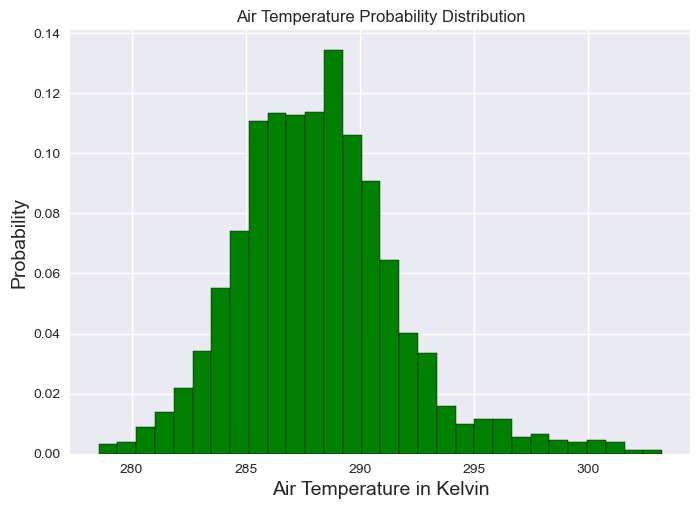

In [36]:
#setting theme for all graphs to follow
plt.style.use('seaborn')

# Plotting Air Temperature
plt.hist(data['Temp Kelvin'], bins=30, ec="k", color = 'g', density = True)

# Adding labels
plt.xlabel('Air Temperature in Kelvin', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.title('Air Temperature Probability Distribution')

plt.show()

The Air Temperature distribution closely resembles a normal distibution, however there appears to be more outliers on the right side of the graph. For the purpose of this study, simplifying this to a normal distibution will be fine. To investigate this, we can compare a normal distribution plotted over this distribution.

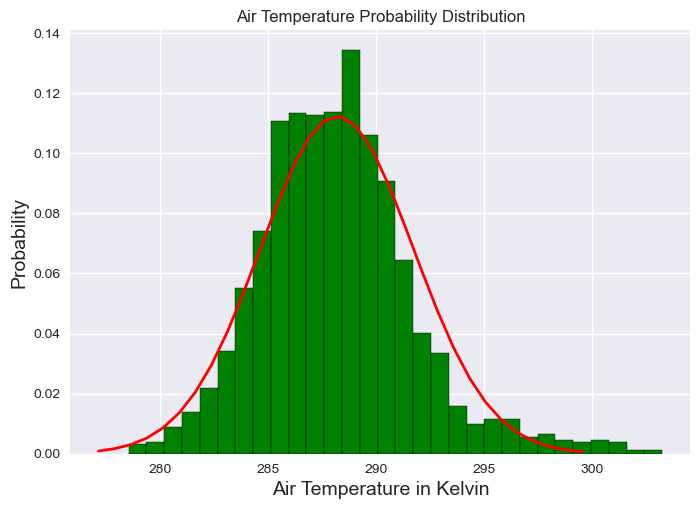

In [37]:
# Generating a random normal distribution to match the Air Temperature distribution
mu, sigma = 288.19, 3.55 # mean and standard deviation
s = np.random.normal(mu, sigma, 2208) # Generating random data in a normal distribution
count, bins, ignored = plt.hist(s, 30, density = True, alpha = 0)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r', alpha = 1)

# Plotting Air Temperature
plt.hist(data['Temp Kelvin'], bins=30, ec="k", color='g', alpha = 1, density = True)
plt.xlabel('Air Temperature in Kelvin', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.title('Air Temperature Probability Distribution')

plt.show()

From comparing the results, it is clear that a normal distribution is a close fit to this data.

#### Air Pressure

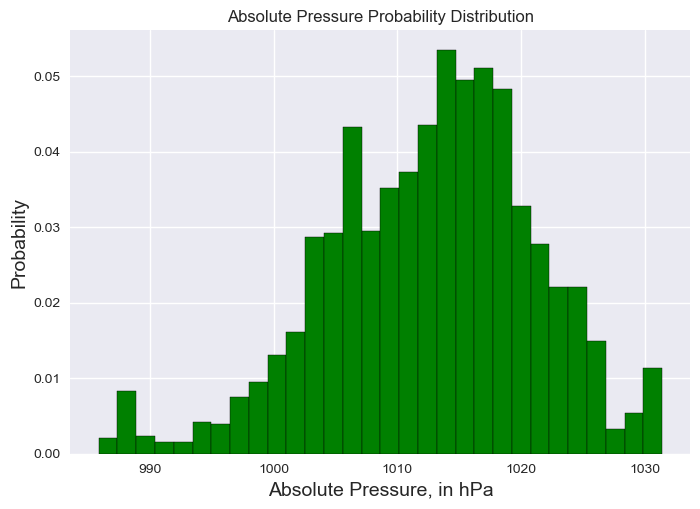

In [38]:
# Plotting Absolute Pressure
plt.hist(data['Absolute Pressure'], bins=30, ec="k", color = 'g', density = True)

# Adding labels
plt.xlabel('Absolute Pressure, in hPa', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.title('Absolute Pressure Probability Distribution')

plt.show()

This does not look to be a perfect normal distribution. To test this, both a normal distribution and a gamma distribution will be fit to the data.

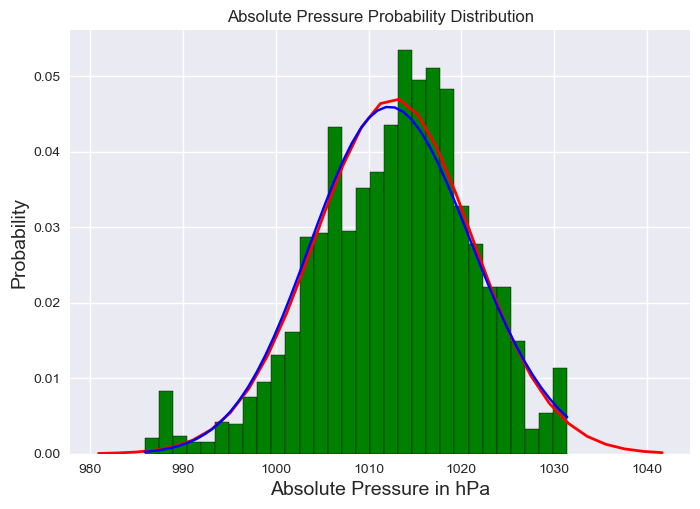

In [39]:
# Generating a random normal distribution to match the Air temperature distribution
mu, sigma = 1012.72, 8.48 # mean and standard deviation
s = np.random.normal(mu, sigma, 2208) # Generating random data in a normal distribution
count, bins, ignored = plt.hist(s, 30, density = True, alpha = 0)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r', alpha = 1)

# Gamma distribution
# Using Scipy to fit a gamma distribution to this data
[aFit, locFit, scaleFit] = scipy.stats.gamma.fit(data['Absolute Pressure'])
x = np.linspace(np.min(data['Absolute Pressure']), np.max(data['Absolute Pressure']))
plt.plot(x, scipy.stats.gamma.pdf(x, aFit, loc = locFit, scale = scaleFit), color='b')

# Plotting Absolute Pressure histogram, for comparison
plt.hist(data['Absolute Pressure'], bins=30, ec="k", color='g', alpha = 1, density = True)
plt.xlabel('Absolute Pressure in hPa', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.title('Absolute Pressure Probability Distribution')

plt.show()

Again, I see this data can be approximatly modeled by using a normal distribution, as shown in red. The gamma distribution in blue does not apprear to match the data any better. There appears to be no benifit for the increased complexity of using a gamma distribution.

#### Wind speed and direction

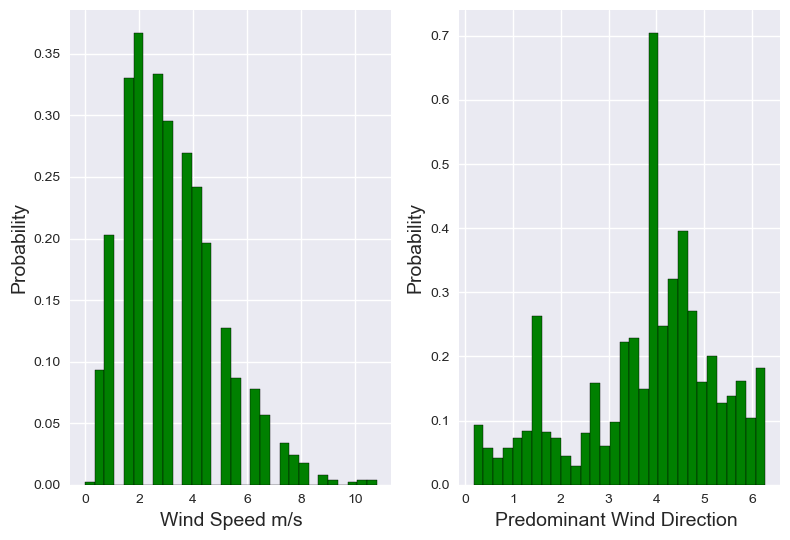

In [40]:
# Using a subplot to show wind speed and direction together
# plotting the wind speed
plt.subplot(1, 2, 1)
plt.hist(data['Wind Speed'], bins=30, ec="k", color='g', density = True)
plt.xlabel('Wind Speed m/s', fontsize=14)
plt.ylabel('Probability', fontsize=14)

# plotting the wind direction
plt.subplot(1, 2, 2)
plt.hist(data['Wind direction'], bins=30, ec="k", color='g', density = True)
plt.xlabel('Predominant Wind Direction ', fontsize=14)
plt.ylabel('Probability', fontsize=14)

plt.tight_layout()
plt.show()

Starting with wind speed, this is not a normal distribution as it is biased to lower wind speeds. A gamma distribution may fit this data better.

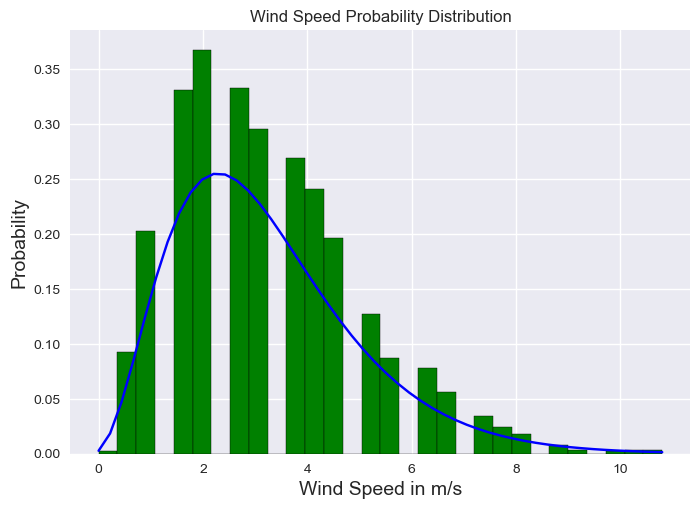

In [41]:
# Trying a gamma distribution
# Using Scipy to fit a gamma distribution to this data
[aFit, locFit, scaleFit] = scipy.stats.gamma.fit(data['Wind Speed'])

# Using Linspace to create bins
x = np.linspace(np.min(data['Wind Speed']), np.max(data['Wind Speed']))
plt.plot(x, scipy.stats.gamma.pdf(x, aFit, loc = locFit, scale = scaleFit), color='b')

# Plotting Wind Speed histogram
plt.hist(data['Wind Speed'], bins=30, ec="k", color='g', density = True)
plt.xlabel('Wind Speed in m/s', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.title('Wind Speed Probability Distribution')
plt.show()

The Gamma distribution fits the wind speed very well. The distribution does not reach the same peek as the recorded data, but this may be explaned by the recoded data having steps with no values, where as the fitted gamma distribution is continuous across the whole range.

#### Now looking at wind direction.

The bar chart above for wind direction looks to be a two peak distribution. I am going to negate the lower peek to simplfy the problem and aim to match the distribution of the larger right peak. 

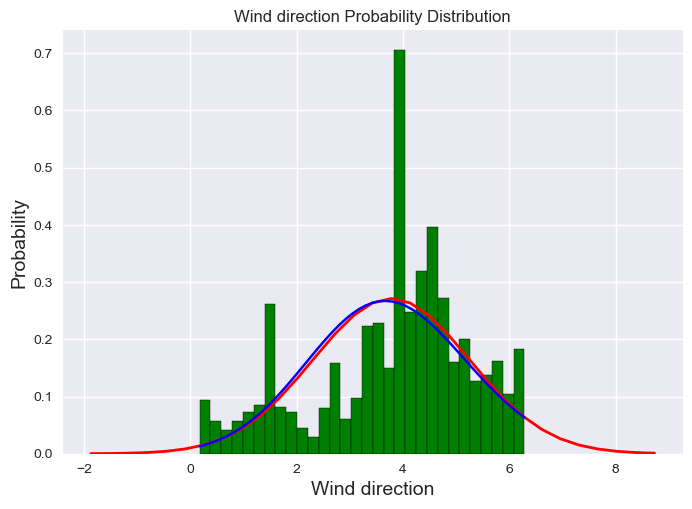

In [42]:
# Generating a random normal distribution to match the Air temperature distribution
mu, sigma = 3.78, 1.47 # mean and standard deviation
s = np.random.normal(mu, sigma, 2208) # Generating random data in a normal distribution
count, bins, ignored = plt.hist(s, 30, density = True, alpha = 0)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r', alpha = 1)

# Also trying a gamma distribution
# Using Scipy to fit a gamma distribution to this data
[aFit, locFit, scaleFit] = scipy.stats.gamma.fit(data['Wind direction'])
x = np.linspace(np.min(data['Wind direction']), np.max(data['Wind direction']))
plt.plot(x, scipy.stats.gamma.pdf(x, aFit, loc = locFit, scale = scaleFit), color='b')

# Plotting Absolute Pressure histogram
plt.hist(data['Wind direction'], bins=30, ec="k", color='g', density = True)
plt.xlabel('Wind direction', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.title('Wind direction Probability Distribution')
plt.show()

A gamma distribution will be a more suitable choice here as it starts and ends with the data. We know that the wind direction can only exist between $0$ and $2\pi$.

#### Looking at Rain fall
Starting with visualising the distribution

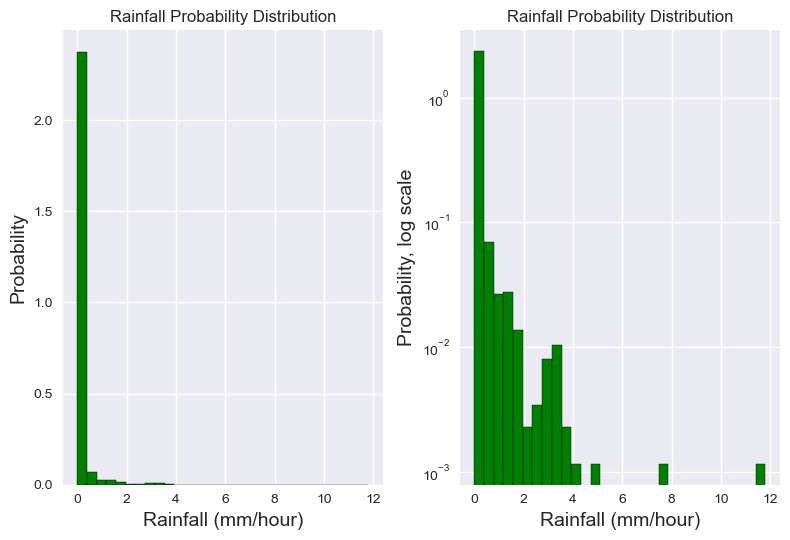

In [43]:
# plotting rainfall
plt.subplot(1, 2, 1)
plt.hist(data["Precipitation Amount"], bins=30, color='g', density = True, ec="k")
plt.xlabel('Rainfall (mm/hour)', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.title('Rainfall Probability Distribution')

# plotting rainfall on a log scale
plt.subplot(1, 2, 2)
plt.hist(data["Precipitation Amount"], bins=30, color='g', density = True, ec="k")
plt.yscale("log") 
plt.xlabel('Rainfall (mm/hour)', fontsize=14)
plt.ylabel('Probability, log scale', fontsize=14)
plt.title('Rainfall Probability Distribution')
plt.tight_layout()

plt.show()

I do not recognise this distribution type, but it appears to be better suited to a log scale for analysis. Multiple metheods of matching this distibution will be tried and the closed match will be chosen.

C:\Users\David\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2606: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


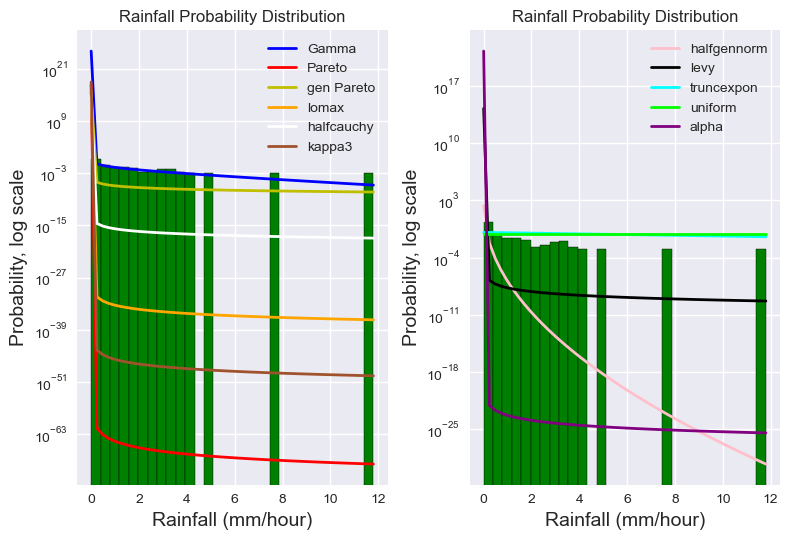

In [44]:
# Trying a gamma distribution
# Using Scipy to fit a gamma distribution to this data
plt.subplot(1, 2, 1)
[aFit, locFit, scaleFit] = scipy.stats.gamma.fit(data["Precipitation Amount"])
x = np.linspace(np.min(data["Precipitation Amount"]), np.max(data["Precipitation Amount"]))
plt.plot(x, scipy.stats.gamma.pdf(x, aFit, loc = locFit, scale = scaleFit), color='b',linewidth=2, label="Gamma")
plt.title('Rainfall Probability Distribution')
plt.yscale("log")

# Trying a pareto distribution
# Using Scipy to fit a pareto distribution to this data
[aFit, locFit, scaleFit] = scipy.stats.pareto.fit(data["Precipitation Amount"])
x = np.linspace(np.min(data["Precipitation Amount"]), np.max(data["Precipitation Amount"]))
plt.plot(x, scipy.stats.pareto.pdf(x, aFit, loc = locFit, scale = scaleFit), color='r', linewidth=2, label="Pareto")

# Trying a genpareto distribution
# Using Scipy to fit a genpareto distribution to this data
[aFit, locFit, scaleFit] = scipy.stats.genpareto.fit(data["Precipitation Amount"])
x = np.linspace(np.min(data["Precipitation Amount"]), np.max(data["Precipitation Amount"]))
plt.plot(x, scipy.stats.genpareto.pdf(x, aFit, loc = locFit, scale = scaleFit), color='y', linewidth=2, label="gen Pareto")

# Trying a lomax distribution
# Using Scipy to fit a lomax distribution to this data
[aFit, locFit, scaleFit] = scipy.stats.lomax.fit(data["Precipitation Amount"])
x = np.linspace(np.min(data["Precipitation Amount"]), np.max(data["Precipitation Amount"]))
plt.plot(x, scipy.stats.lomax.pdf(x, aFit, loc = locFit, scale = scaleFit), color='orange', linewidth=2, label="lomax")

# Trying a halfcauchy distribution
# Using Scipy to fit a halfcauchy distribution to this data
[locFit, scaleFit] = scipy.stats.halfcauchy.fit(data["Precipitation Amount"])
x = np.linspace(np.min(data["Precipitation Amount"]), np.max(data["Precipitation Amount"]))
plt.plot(x, scipy.stats.halfcauchy.pdf(x, loc = locFit, scale = scaleFit), color='w', linewidth=2, label="halfcauchy")

# Trying a kappa3 distribution
# Using Scipy to fit a kappa3 distribution to this data
[aFit, locFit, scaleFit] = scipy.stats.kappa3.fit(data["Precipitation Amount"])
x = np.linspace(np.min(data["Precipitation Amount"]), np.max(data["Precipitation Amount"]))
plt.plot(x, scipy.stats.kappa3.pdf(x, aFit, loc = locFit, scale = scaleFit), color='sienna',linewidth=2, label="kappa3")

# Plotting Absolute Pressure histogram
plt.hist(data["Precipitation Amount"], bins=30, color='g', density = True, ec="k")
plt.xlabel('Rainfall (mm/hour)', fontsize=14)
plt.ylabel('Probability, log scale', fontsize=14)
plt.yscale("log")
plt.legend(loc = 'upper right')

# Trying a halfgennorm distribution
# Using Scipy to fit a halfgennorm distribution to this data
plt.subplot(1, 2, 2)
[aFit, locFit, scaleFit] = scipy.stats.halfgennorm.fit(data["Precipitation Amount"])
x = np.linspace(np.min(data["Precipitation Amount"]), np.max(data["Precipitation Amount"]))
plt.plot(x, scipy.stats.halfgennorm.pdf(x, aFit, loc = locFit, scale = scaleFit), color='pink', linewidth=2, label="halfgennorm")

# Trying a levy distribution
# Using Scipy to fit a levy distribution to this data
[locFit, scaleFit] = scipy.stats.levy.fit(data["Precipitation Amount"])
x = np.linspace(np.min(data["Precipitation Amount"]), np.max(data["Precipitation Amount"]))
plt.plot(x, scipy.stats.levy.pdf(x, loc = locFit, scale = scaleFit), color='black', linewidth=2, label="levy")

# Trying a truncexpon distribution
# Using Scipy to fit a truncexpon distribution to this data
[aFit, locFit, scaleFit] = scipy.stats.truncexpon.fit(data["Precipitation Amount"])
x = np.linspace(np.min(data["Precipitation Amount"]), np.max(data["Precipitation Amount"]))
plt.plot(x, scipy.stats.truncexpon.pdf(x, aFit, loc = locFit, scale = scaleFit), color='cyan', linewidth=2, label="truncexpon")

# Trying a uniform distribution, because why not at this stage!
# Using Scipy to fit a levy distribution to this data
[locFit, scaleFit] = scipy.stats.uniform.fit(data["Precipitation Amount"])
x = np.linspace(np.min(data["Precipitation Amount"]), np.max(data["Precipitation Amount"]))
plt.plot(x, scipy.stats.uniform.pdf(x, loc = locFit, scale = scaleFit), color='lime', linewidth=2, label="uniform")

# Trying a alpha distribution
# Using Scipy to fit a alpha distribution to this data
[aFit, locFit, scaleFit] = scipy.stats.alpha.fit(data["Precipitation Amount"])
x = np.linspace(np.min(data["Precipitation Amount"]), np.max(data["Precipitation Amount"]))
plt.plot(x, scipy.stats.alpha.pdf(x, aFit, loc = locFit, scale = scaleFit), color='purple', linewidth=2, label="alpha")

# Plotting Absolute Pressure histogram
plt.hist(data["Precipitation Amount"], bins=30, color='g', density = True, ec="k")
plt.xlabel('Rainfall (mm/hour)', fontsize=14)
plt.ylabel('Probability, log scale', fontsize=14)
plt.yscale("log")
plt.legend(loc = 'upper right')
plt.title('Rainfall Probability Distribution')

plt.tight_layout()

plt.show()

#### Looking at some of these distributions

##### Gamma
The Gamma distribution in blue appears to greatly over estimate the the value at zero, but then closely matched the values past zero.

##### A generalized Pareto
The generalized Pareto in Yellow is closer to the correct value at Zero. There is a slight error across the rest of the values.

##### Pareto
The Pareto is slightly worse than the generalized Pareto at zero and then greatly underestimates the probability across the rest of the data.

##### HalfGenNorm
On the right graph in pink, this distribution is the closest to the correct order of magnitude at the zero value. However, this distribution greatly underestimates values greater than 1.

#### The chosen distribution to model the rainfall is the gamma distribution

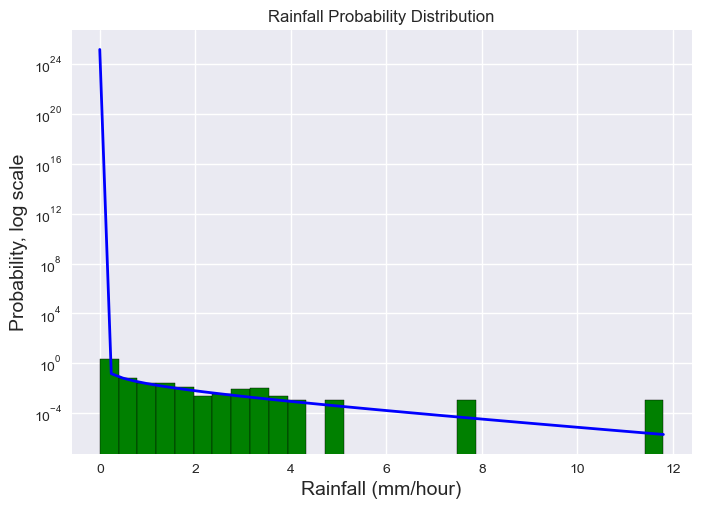

In [45]:
# choosing the gamma distribution
# Using Scipy to fit a gamma distribution to this data
[RainaFit, RainlocFit, RainscaleFit] = scipy.stats.gamma.fit(data["Precipitation Amount"])
x = np.linspace(np.min(data["Precipitation Amount"]), np.max(data["Precipitation Amount"]))
plt.plot(x, scipy.stats.gamma.pdf(x, RainaFit, loc = RainlocFit, scale = RainscaleFit), color='b',linewidth=2, label="Gamma")
plt.yscale("log")

# Plotting Absolute Pressure histogram
plt.hist(data["Precipitation Amount"], bins=30, color='g', density = True, ec="k")
plt.xlabel('Rainfall (mm/hour)', fontsize=14)
plt.ylabel('Probability, log scale', fontsize=14)
plt.yscale("log")
plt.title('Rainfall Probability Distribution')

plt.show()

## 4. Looking at the relationship between variables

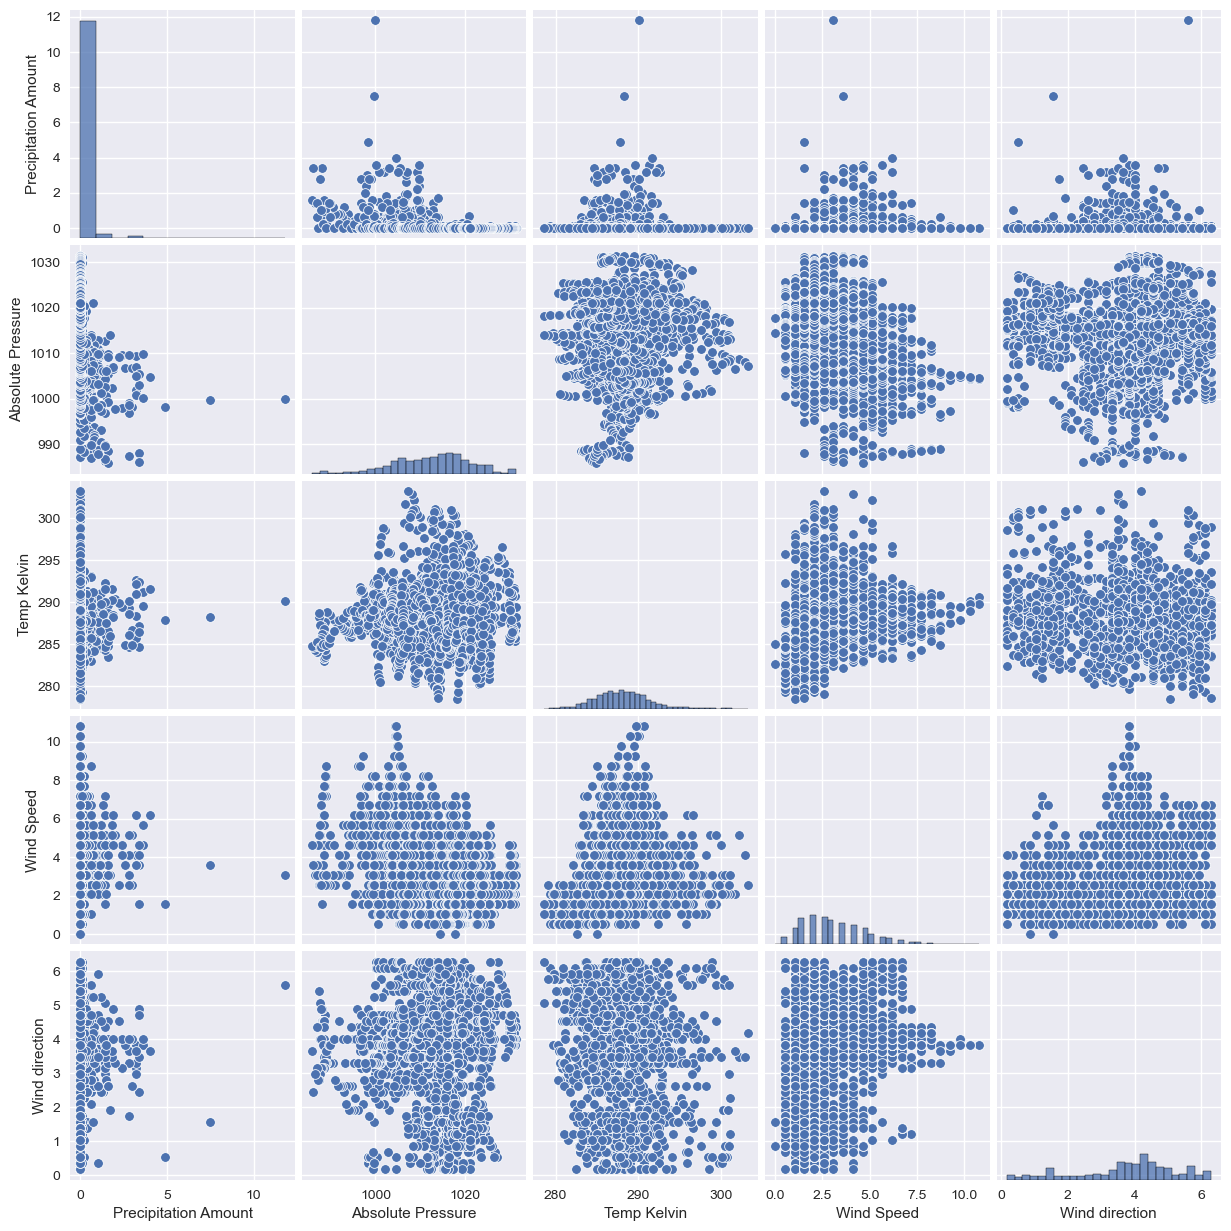

In [46]:
sns.pairplot(data)
plt.show()

Loading a function to graph the standard deviation ontop of a scatter plot, Taken from reference 2

In [47]:
# The code in this cell has been taken from reference 2

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

#### First looking closer at the relationship between Temperature and Pressure using a scatter plot
This plot will be created using the real data

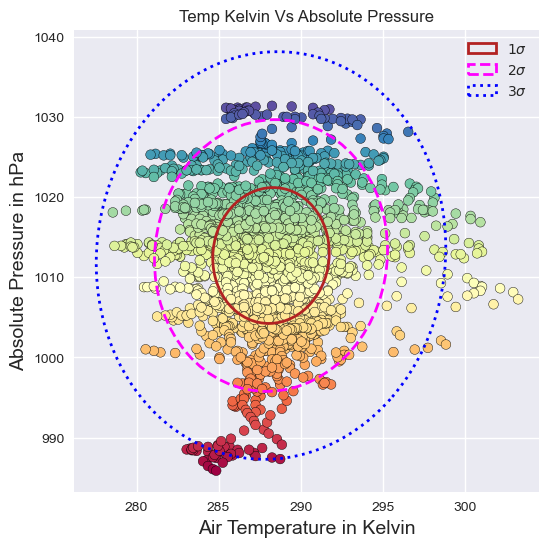

In [48]:
fig, ax_nstd = plt.subplots(figsize=(6, 6))
plt.scatter(data['Temp Kelvin'], data['Absolute Pressure'], c = data['Absolute Pressure'], cmap='Spectral', edgecolor = 'k')

# Adding standard deviation lines
confidence_ellipse(data['Temp Kelvin'], data['Absolute Pressure'],ax_nstd, n_std=1,
                   label=r'$1\sigma$', edgecolor='firebrick', linewidth=2)

confidence_ellipse(data['Temp Kelvin'], data['Absolute Pressure'],ax_nstd, n_std=2,
                   label=r'$2\sigma$', edgecolor='fuchsia', linestyle='--', linewidth=2)

confidence_ellipse(data['Temp Kelvin'], data['Absolute Pressure'],ax_nstd, n_std=3,
                   label=r'$3\sigma$', edgecolor='blue', linestyle=':', linewidth=2)

ax_nstd.set_title('Temp Kelvin Vs Absolute Pressure')
plt.xlabel('Air Temperature in Kelvin', fontsize=14)
plt.ylabel('Absolute Pressure in hPa', fontsize=14)
ax_nstd.legend()
plt.show()

#### Checking if two combined normally distributed variables can create the same distribution
This distribution will be created by combining the two normal distibutions, which were fit to each of the variables above in section 3

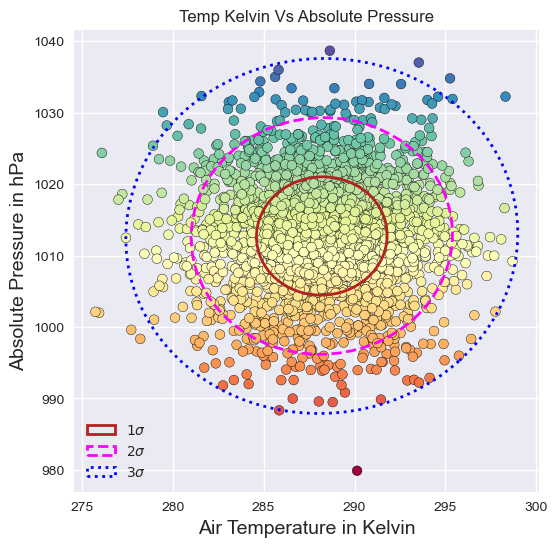

In [49]:
# Generating a random normal distribution to match the Air temperature distribution
mu, sigma = 288.19, 3.55 # mean and standard deviation
airTemp = np.random.normal(mu, sigma, 2208) # Generating random data in a normal distribution

# Generating a random normal distribution to match the Air Pressure distribution
mu, sigma = 1012.72, 8.48 # mean and standard deviation
airPressure = np.random.normal(mu, sigma, 2208) # Generating random data in a normal distribution

fig, ax_nstd = plt.subplots(figsize=(6, 6))
plt.scatter(airTemp, airPressure, c = airPressure, cmap='Spectral', edgecolor = 'k')

# Adding standard deviation lines
confidence_ellipse(airTemp, airPressure,ax_nstd, n_std=1,
                   label=r'$1\sigma$', edgecolor='firebrick', linewidth=2)

confidence_ellipse(airTemp, airPressure,ax_nstd, n_std=2,
                   label=r'$2\sigma$', edgecolor='fuchsia', linestyle='--', linewidth=2)

confidence_ellipse(airTemp, airPressure,ax_nstd, n_std=3,
                   label=r'$3\sigma$', edgecolor='blue', linestyle=':', linewidth=2)

ax_nstd.set_title('Temp Kelvin Vs Absolute Pressure')
plt.xlabel('Air Temperature in Kelvin', fontsize=14)
plt.ylabel('Absolute Pressure in hPa', fontsize=14)
ax_nstd.legend()

plt.show()

From comparing the two distributions, it can be seen that this method creates an accurate synthesized data set for Air Temperature Vs Air Pressure. This method will be used when synthesizing the final data set.

#### Trying the same method with wind speed and direction 
First the wind speed and wind direction will be plot in a Polar plot, to observe any trends in the data.

C:\Users\David\AppData\Local\Temp\ipykernel_15120\376303874.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks_labels)


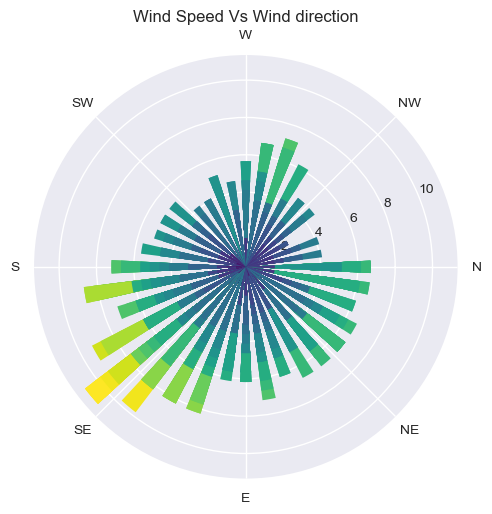

In [50]:
# colouring based off wind speed
colors = plt.cm.viridis((data['Wind Speed'])/10)
x_ticks_labels = ["N", "NW", "W", "SW", "S", "SE", "E", "NE"]

# Setting up a polar plot
ax = plt.subplot(projection='polar')
ax.bar(data['Wind direction'], data['Wind Speed'], color=colors, width = 0.1)
ax.set_xticklabels(x_ticks_labels)

plt.title('Wind Speed Vs Wind direction')

plt.show()

Checking if a combination of the two fitting distributions above can model this data effectively

C:\Users\David\AppData\Local\Temp\ipykernel_15120\3509640141.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks_labels)


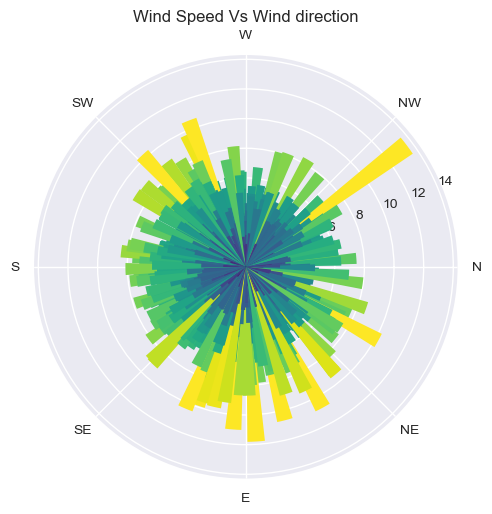

In [51]:
# modeling the wind speed
aFit, locFit, scaleFit  = 3.65, -0.17, 0.93
windSpeed = scipy.stats.gamma.rvs( aFit, loc = locFit, scale = scaleFit, size=2208)

# modeling the wind direction
aFit, locFit, scaleFit  = 270.44, -20.84, 0.09
windDirection = scipy.stats.gamma.rvs( aFit, loc = locFit, scale = scaleFit, size=2208)

plt.subplot(1, 2, 1)
colors = plt.cm.viridis((windSpeed)/10)
x_ticks_labels = ["N", "NW", "W", "SW", "S", "SE", "E", "NE"]

ax = plt.subplot(projection='polar')
ax.bar(windDirection , windSpeed, color=colors, width = 0.1)
ax.set_xticklabels(x_ticks_labels)
plt.title('Wind Speed Vs Wind direction')

plt.show()

This has not closely matched the data above. Firstly, the wind direction above appears to have been a discrete variable rather than a continuous variable in the recorded data. Secondly the wind speed was far more dependent on the wind direction in the recorded data.

Instead, the wind direction will be divided up into 4 groups. The wind speed distribution will be calculated for each group. Then synthesized data will be created in 2 steps, first randomly asigning a wind direction, and then wind speed using that group.

C:\Users\David\AppData\Local\Temp\ipykernel_15120\3321198937.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks_labels)


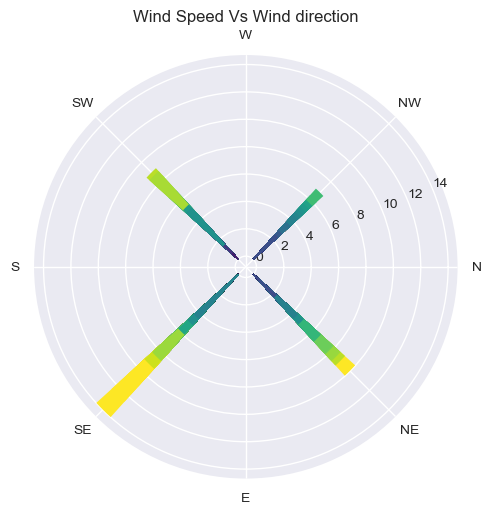

In [52]:
# Cutting circle into 4 groups
Group0 = data.loc[(data['Wind direction'] <= 1.57079633)]
Group1 = data.loc[((data['Wind direction'] > 1.57079633) & (data['Wind direction'] <= 3.14159265))]
Group2 = data.loc[((data['Wind direction'] > 3.14159265) & (data['Wind direction'] <= 4.71238898))]
Group3 = data.loc[((data['Wind direction'] > 4.71238898) & (data['Wind direction'] <= 6.28318531))]

# fitting a gamma distribution to each of the 4 groups
[NWaFit, NWlocFit, NWscaleFit] = scipy.stats.gamma.fit(Group0['Wind Speed'])
[SWaFit, SWlocFit, SWscaleFit] = scipy.stats.gamma.fit(Group1['Wind Speed'])
[SEaFit, SElocFit, SEscaleFit] = scipy.stats.gamma.fit(Group2['Wind Speed'])
[NEaFit, NElocFit, NEscaleFit] = scipy.stats.gamma.fit(Group3['Wind Speed'])

# finding the weights of being asigned into each group
distribution_weights = [len(Group0)/len(data), len(Group1)/len(data), len(Group2)/len(data), len(Group3)/len(data)]

# using choice to randomly choose the middle of one of the 4 groups, based off of the distribution weights
grouped_wind_direction = np.random.choice([0.79, 2.36, 3.93, 5.5], 2208, p=distribution_weights)

#setting up a blank list for wind speed
grouped_wind_speed = []

# matching wind speed to the wind direction, in 4 groups.
for value in grouped_wind_direction:
        if value == 0.79:
            # Using Scipy to fit a gamma distribution to this data
            wind_speed = scipy.stats.gamma.rvs(NWaFit, loc = NWlocFit, scale = NWscaleFit, size=1)
            grouped_wind_speed.append(wind_speed[0])
            
        if value == 2.36:
            # Using Scipy to fit a gamma distribution to this data
            wind_speed = scipy.stats.gamma.rvs(SWaFit, loc = SWlocFit, scale = SWscaleFit, size=1)
            grouped_wind_speed.append(wind_speed[0])

        if value == 3.93:
            # Using Scipy to fit a gamma distribution to this data
            wind_speed = scipy.stats.gamma.rvs(SEaFit, loc = SElocFit, scale = SEscaleFit, size=1)
            grouped_wind_speed.append(wind_speed[0])
            
        if value == 5.5:
            # Using Scipy to fit a gamma distribution to this data    
            wind_speed = scipy.stats.gamma.rvs(NEaFit, loc = NElocFit, scale = NEscaleFit, size=1)
            grouped_wind_speed.append(wind_speed[0])

# converting the result from a list to an array
grouped_wind_speed = np.array(grouped_wind_speed)

colors = plt.cm.viridis((grouped_wind_speed)/10)
x_ticks_labels = ["N", "NW", "W", "SW", "S", "SE", "E", "NE"]

ax = plt.subplot(projection='polar')
ax.bar(grouped_wind_direction , grouped_wind_speed, color=colors, width = 0.1)
ax.set_xticklabels(x_ticks_labels)
plt.title('Wind Speed Vs Wind direction')

plt.show()

This model does not have as much detail in the wind direction, but the correlation is truer to the origional data, with the largest wind speeds comming from the South East and the lower wind speeds comming from the North West.

## 5. Synthesising new data

Using the distibutions defined above, a new data set will be syntesised and compared to the origional data.

In [53]:
newData = pd.DataFrame()

# Generating rain data
newData['Precipitation Amount'] = scipy.stats.gamma.rvs(RainaFit, loc = RainlocFit, scale = RainscaleFit, size=2208)

# Generating a random normal distribution to match the Air Pressure distribution
mu, sigma = 1012.72, 8.48 # mean and standard deviation
newData['Absolute Pressure'] = np.random.normal(mu, sigma, 2208) # Generating random data in a normal distribution

# Generating a random normal distribution to match the Air temperature distribution
mu, sigma = 288.19, 3.55 # mean and standard deviation
newData['Temp Kelvin'] = np.random.normal(mu, sigma, 2208) # Generating random data in a normal distribution

# Using choice to randomly choose a wind direction
grouped_wind_direction = np.random.choice([0.79, 2.36, 3.93, 5.5], 2208, p=distribution_weights)

# Using groupings to fit the wind speed to these wind directions
grouped_wind_speed = []

for value in grouped_wind_direction:
        if value == 0.79:
            # Using Scipy to fit a gamma distribution to this data
            wind_speed = scipy.stats.gamma.rvs(NWaFit, loc = NWlocFit, scale = NWscaleFit, size=1)
            grouped_wind_speed.append(wind_speed[0])
            
        if value == 2.36:
            # Using Scipy to fit a gamma distribution to this data
            wind_speed = scipy.stats.gamma.rvs(SWaFit, loc = SWlocFit, scale = SWscaleFit, size=1)
            grouped_wind_speed.append(wind_speed[0])

        if value == 3.93:
            # Using Scipy to fit a gamma distribution to this data
            wind_speed = scipy.stats.gamma.rvs(SEaFit, loc = SElocFit, scale = SEscaleFit, size=1)
            grouped_wind_speed.append(wind_speed[0])
            
        if value == 5.5:
            # Using Scipy to fit a gamma distribution to this data    
            wind_speed = scipy.stats.gamma.rvs(NEaFit, loc = NElocFit, scale = NEscaleFit, size=1)
            grouped_wind_speed.append(wind_speed[0])

newData['Wind Speed'] = np.array(grouped_wind_speed)

# Using choice to randomly choose a wind direction
newData['Wind direction'] = grouped_wind_direction

## Compairing the synthesized data to the real data

In [54]:
# joining the data sets together, to use a pairplot
# creating a new column, to use as the hue
data['state'] = 0
newData['state'] = 1

allData =  pd.concat([data, newData], ignore_index=True)

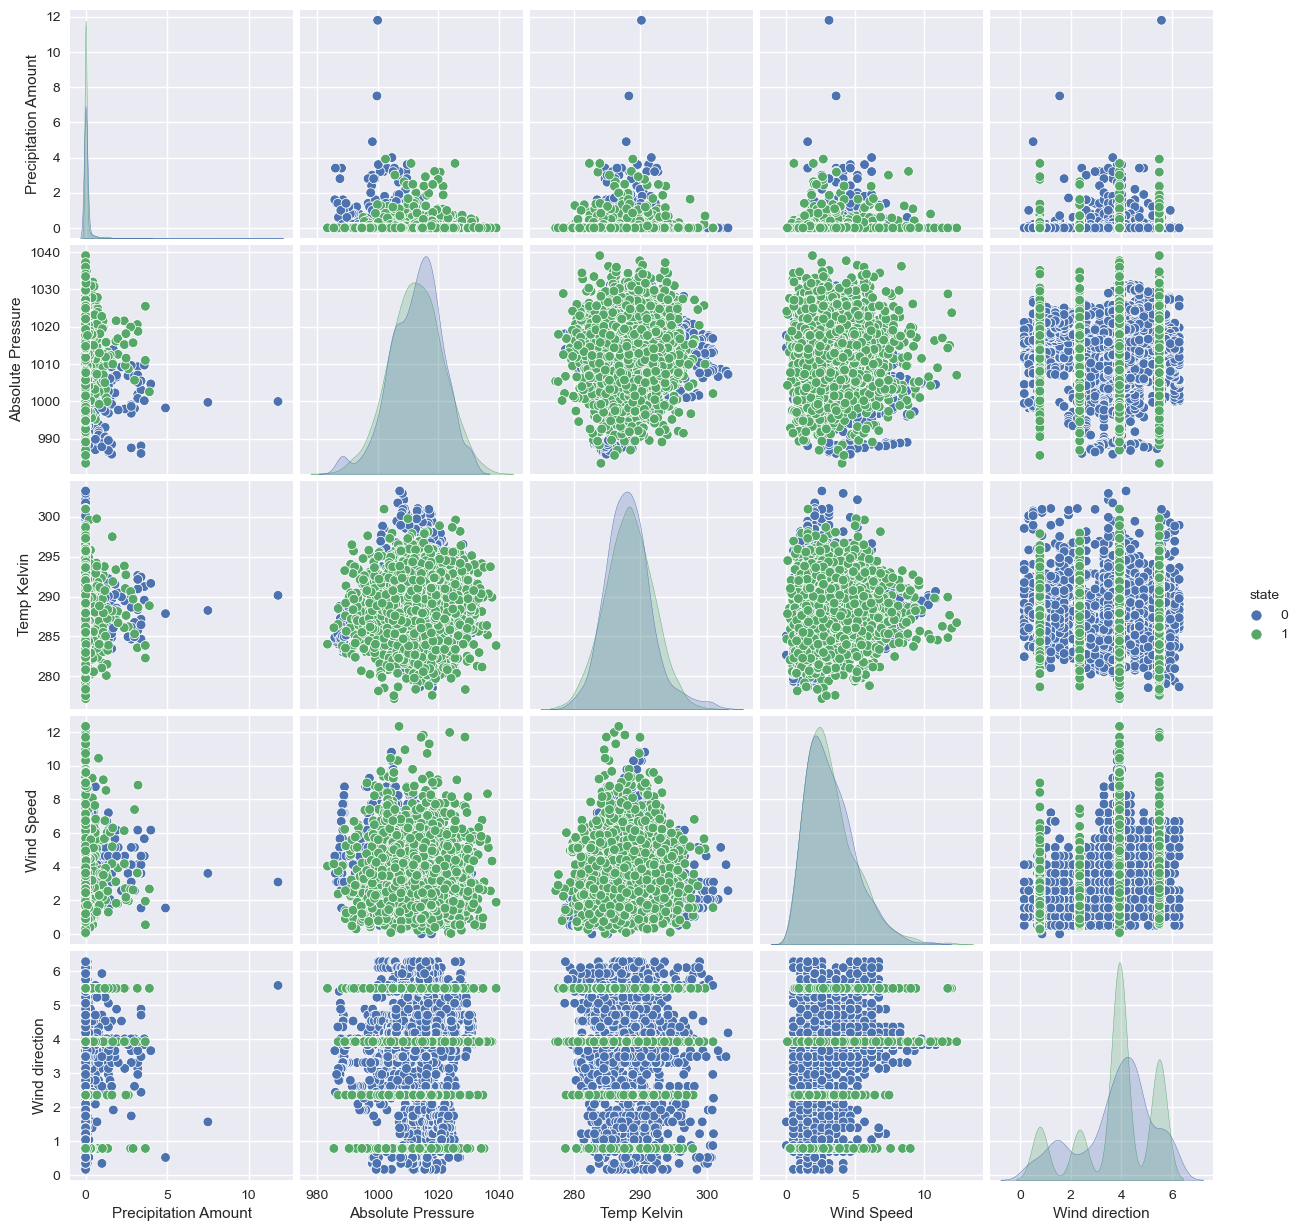

In [55]:
sns.pairplot(allData, hue = 'state')
plt.show()

#### 0 being the real world recorded data & 1 being the syntesised data

## 6. Review 
The syntesised data matches the real world data well in may aspects, but it also has alot of shortcomings. As expected, the Air Temperature and Air Pressure are closely correlated with the real world data, given both are normally distributed.

The Air Temperature Vs Percipitation Amount, this does look to loosly fit the real world data, with just the combinations of the individual distributions modeled.

The Air Temperature Vs Wind Speed. Again this does closely match the real world data, given both variables are close to being normally distributed.

The Air Temperature Vs Wind Direction. Due to the method used to correlated the wind speed with the wind direction, the syntesised data does not have the same level of detail as the real world data. That being said, the synthesised data does look like it loosly fits the real world data.

The Absolute Pressure Vs Percipitation Amount, this does look to loosly fit the real world data, with just the combinations of the individual distributions modeled. The syntesised data does not produce the high rainfall outliers that the real world data has.

The Absolute Pressure Vs Wind Speed, the syntesised data does over estimate the wind speed at higher air pressures. Aside from this, the rest of the data is closely correlated.

The Absolute Pressure Vs Wind Direction, the syntesised data does not closly correlate with the real world data for the North West direction, the other directions are closely correlated.

The Wind Speed Vs Wind Direction, there is a clear correlation between the two data sets. The detail is not great given the wind direction was only divided into 4 groups.

The Wind Speed Vs Percipitation Amount, there is a rough correlation here.

The  Wind Direction Vs Percipitation Amount, This looks to be the worst correlation between variables. 

### Conclusion 
This method has created a usable data set bases off the statistics of the real world data set. This method was curde and in many instances ignored the correlation beween variables, but as seen above this still produced a reasonable syntesised data set. More goupings between variables could have been used, as was done with the wind direction and wind speed, to produce a closer to real life data set. This data could also be treated as a time series instead of as discrete rows to produce a more accurate data set.

## References

- Histograms https://www.tutorialspoint.com/setting-a-relative-frequency-in-a-matplotlib-histogram
- Scatter plot standard deviation https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html#sphx-glr-gallery-statistics-confidence-ellipse-py
- gamma distribution https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html#scipy.stats.gamma
- random number generator https://numpy.org/doc/stable/reference/random/generator.html
- list to array geeksforgeeks.org/convert-python-list-to-numpy-arrays/
- fitting a distributions to a continuous variable using scipy https://www.youtube.com/watch?v=-NnjfDkWy0Y&t=149s&ab_channel=MikeSaint-Antoine
- more fitting distributions https://www.youtube.com/watch?v=TwbJCt36_DU&ab_channel=MikeSaint-Antoine
- scatter plots https://www.youtube.com/watch?v=tmrXuom85TY&t=417s&ab_channel=MattMacarty